In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from tqdm import tqdm
import pandas as pd
import os
import pickle

# loading environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# Define the pydantic class with JSON schema for hate speech detection
class HateSpeechAnalysis(BaseModel):
    '''
    A pydantic class that specifies the json schema of the hate speech detection task
    '''
    classification: str = Field(
        ..., description="Classification of the message: 'normal' or 'hate speech'"
    )
    confidence: float = Field(
        ..., ge=0, le=1, description="Confidence score of the classification (0 to 1)"
    )
    reasoning: str = Field(..., description="Brief explanation for the classification")

    class Config:
        json_schema_extra = {
            "example": {
                "classification": "normal",
                "confidence": 0.95,
                "reasoning": "The message contains no offensive language or discriminatory content.",
            }
        }


In [3]:
# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)


In [4]:
# Create a prompt template for hate speech detection
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an AI trained to detect hate speech."
        "Analyze the given message and determine if it's normal or hate speech."
        "Provide a classification, confidence score, and brief reasoning.",
    ),
    ("human", "Analyze the following message for hate speech: {message}"),
])


In [ ]:
# Create the chain with structured output
chain = prompt | llm.with_structured_output(HateSpeechAnalysis, include_raw=True)


In [ ]:
# Example messages to test
messages = [
    "I love spending time with my family and friends.",
    "All people from that country are criminals and should be deported!",
    "The weather is beautiful today.",
    "All these black niggers are destroying our country",
    "I liked today's party a lot!"
]
results = []
for message in messages:
    result = chain.invoke({"message": message})
    results.append(result)
    print(f"\nAnalysis for: '{message}'")
    print(f"Classification: {result['parsed'].classification}")
    print(f"Confidence: {result['parsed'].confidence:.2f}")
    print(f"Reasoning: {result['parsed'].reasoning}")

In [ ]:
results[0]['raw'].response_metadata

In [36]:
records = []
for idx in range(len(results)):
    record = {
    'id': results[idx]['raw'].id,
    'prompt_tokens': results[idx]['raw'].response_metadata['token_usage']['prompt_tokens'],
    'completion_tokens': results[idx]['raw'].response_metadata['token_usage']['completion_tokens']
    }
    records.append(record)

In [ ]:
est_df = pd.DataFrame.from_records(records)
est_df['total_tokens'] = est_df['prompt_tokens'] + est_df['completion_tokens']
est_df[['prompt_tokens', 'completion_tokens', 'total_tokens']].mean()

In [ ]:
### usage estimates running the code (sequentially)
# RPM (Requests per minute) = 60
# TPM (tokens per minute) = 60 * 220 = 13200

# now let's use this configuration to process the messages in the hateXplain dataset

In [4]:
dataset = pd.read_csv('../data/hateXplain_clean.csv')
dataset.head()

,id,clean_message,majority_vote,relevant_pieces
0,1252707503441313794_twitter,why are you repeating yourself are you a littl...,hate speech,retarded
1,1103385226921762816_twitter,well she ’ muslim so of course she hates the j...,normal,muslim she hates the jews jew hatred islam
2,1169443635869487105_twitter,lol not me i don ’ t deal with bms not outside...,hate speech,ghetto
3,17372469_gab,an these nigger biches look like godzilla nasty,normal,nigger
4,1168407844095483904_twitter,yeah humnh what how do i use this app i ’ m al...,hate speech,retarded


In [7]:
dataset.shape

(1142, 4)

In [8]:
# Prepare the input data
input_data = [{"message": msg} for msg in dataset["clean_message"]]


In [10]:
classification_results = []
# perform inference sequentially
for idx, input in tqdm(enumerate(input_data), total=len(input_data)):
    try:
        result = chain.invoke(input)
        classification_results.append(result)
    except:
        print(f"problem processing message with index {idx}. Adding a placeholder to the classification results")
        classification_results.append(None)


100%|██████████| 1142/1142 [24:45<00:00,  1.30s/it]


### Parsing classification results

In [11]:
classification_results[0]

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5pCyXjjDRVMY2v6fVFB8jjZc', 'function': {'arguments': '{"classification":"hate speech","confidence":0.85,"reasoning":"The term \'retarded\' is considered derogatory and offensive when used to describe someone\'s mental capacity. This language can perpetuate stigma against individuals with intellectual disabilities, which classifies it as hate speech."}', 'name': 'HateSpeechAnalysis'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 175, 'total_tokens': 231, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-9ad6dbca-b50d-40ee-9a39-0db9b4854631-0', tool_calls=[{'name': 'HateSpeechAnalysis', 'args': {'classification': 'hate speech', 'confidence': 0.85, 'reasoning': "The term 'retarded' is considered derogatory an

In [16]:
len(classification_results)

1142

In [7]:
# Creating the columns
dataset['classification'] = ''
dataset['confidence'] = ''
dataset['reasoning'] = ''

# populating the columns
for idx in range(len(dataset)):
    dataset.loc[idx, 'classification'] = classification_results[idx]['parsed'].classification
    dataset.loc[idx, 'confidence'] = classification_results[idx]["parsed"].confidence
    dataset.loc[idx, 'reasoning'] = classification_results[idx]["parsed"].reasoning

In [8]:
dataset.head()

,id,clean_message,majority_vote,relevant_pieces,classification,confidence,reasoning
0,1252707503441313794_twitter,why are you repeating yourself are you a littl...,hate speech,retarded,hate speech,0.85,The term 'retarded' is considered derogatory a...
1,1103385226921762816_twitter,well she ’ muslim so of course she hates the j...,normal,muslim she hates the jews jew hatred islam,hate speech,0.95,The message contains a generalization about Mu...
2,1169443635869487105_twitter,lol not me i don ’ t deal with bms not outside...,hate speech,ghetto,hate speech,0.85,The message contains derogatory language ('ghe...
3,17372469_gab,an these nigger biches look like godzilla nasty,normal,nigger,hate speech,0.95,The message contains a racial slur ('nigger') ...
4,1168407844095483904_twitter,yeah humnh what how do i use this app i ’ m al...,hate speech,retarded,hate speech,0.85,The use of the term 'retarded' is derogatory a...


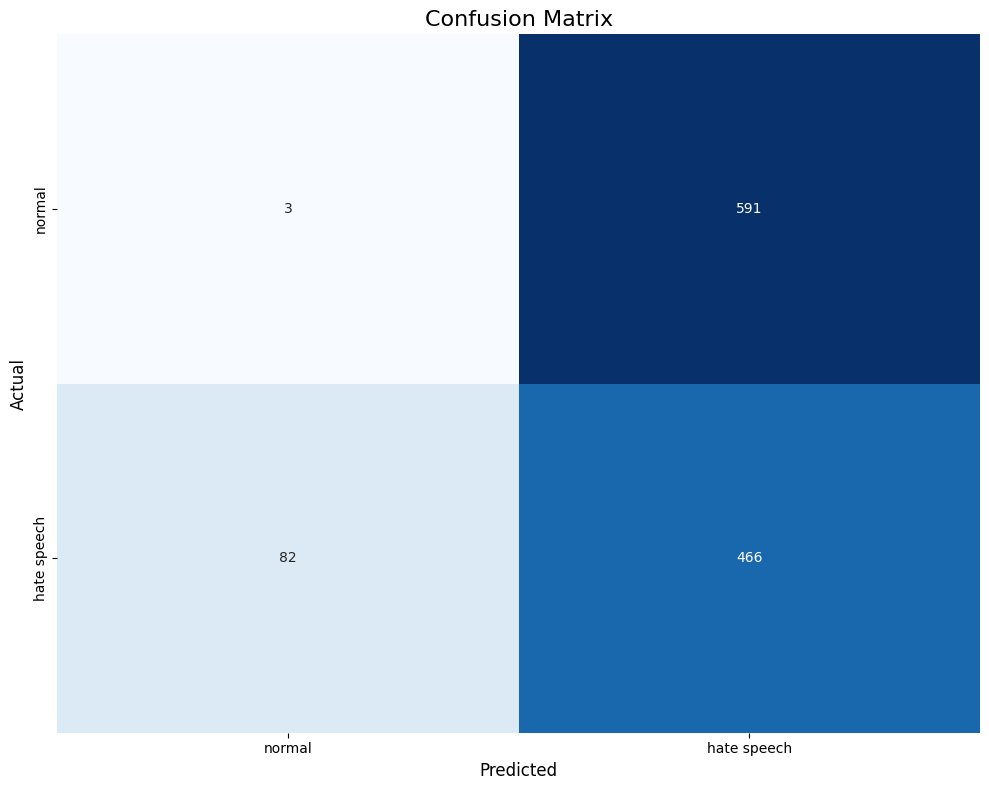

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_to_int = {'normal': 0, 'hate speech': 1}
y_true = dataset["majority_vote"].map(label_to_int)
y_pred = dataset["classification"].map(label_to_int)
# Create the confusion matrix

cm = confusion_matrix(y_true, y_pred)

# Create labels for the classes 
class_names = ["normal", "hate speech"] 

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False
)

# Set title and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report, roc_auc_score, roc_auc_score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.01      0.01       594
           1       0.44      0.85      0.58       548

    accuracy                           0.41      1142
   macro avg       0.24      0.43      0.29      1142
weighted avg       0.23      0.41      0.28      1142



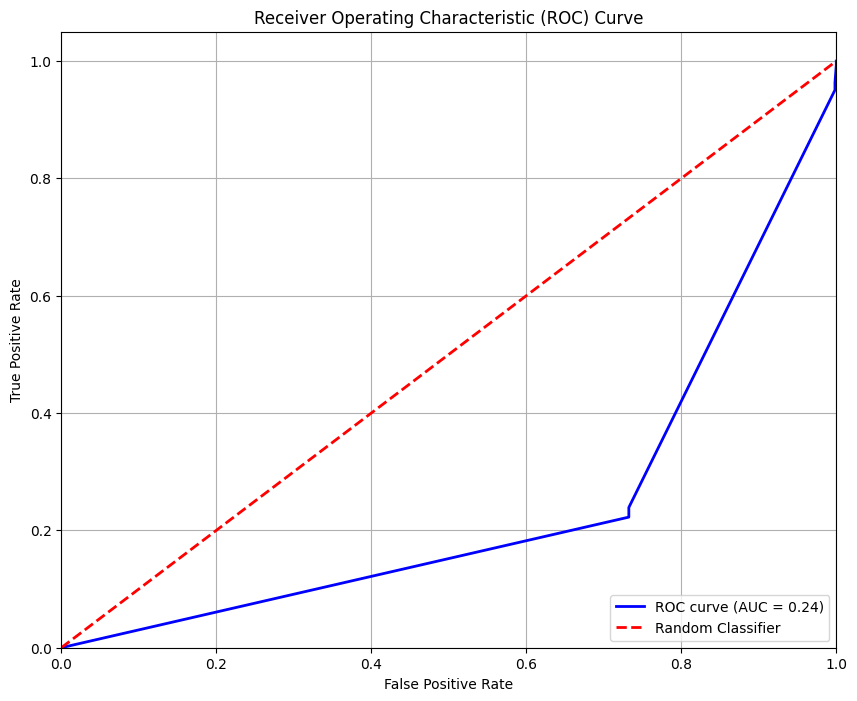

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities
y_scores = dataset["confidence"]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()


In [14]:
dataset.to_csv('../data/final_dataset_exp1.csv', index=False)